In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
df = pd.read_csv('availability.csv')

df.rename(columns={'last_update': 'time_of_day'}, inplace=True)
df = df.drop(columns=["status"])
df['time_of_day'] = pd.to_datetime(df['time_of_day'])

specified_date_time = pd.to_datetime('2024-02-25 15:03:04')

df = df[df['time_of_day'] >= specified_date_time]
df2 = pd.read_csv('weather.csv')
df2['time_of_day'] = pd.to_datetime(df2['time_of_day'])
df2 = df2.drop(columns=["main"])

merged_df = pd.merge_asof(df.sort_values('time_of_day'), df2.sort_values('time_of_day'), 
                          by='station_id', on='time_of_day', direction='nearest')




In [2]:
merged_df['wind_speed'] = merged_df['wind_speed'].interpolate(method='linear')
merged_df['temperature'] = merged_df['temperature'].interpolate(method='linear')
merged_df


,station_id,time_of_day,available_bike_stands,bike_stands,available_bikes,description,temperature,wind_speed
0,42,2024-02-25 15:03:04,0,30,30,broken clouds,7,9.77
1,51,2024-02-25 15:03:06,34,40,6,broken clouds,8,9.77
2,32,2024-02-25 15:03:06,0,30,30,broken clouds,8,9.77
3,18,2024-02-25 15:03:07,6,30,24,broken clouds,7,9.77
4,57,2024-02-25 15:03:08,23,23,0,broken clouds,7,9.77
...,...,...,...,...,...,...,...,...
490185,28,2024-03-20 22:49:29,26,30,4,clear sky,6,4.12
490186,108,2024-03-20 22:49:33,27,35,8,clear sky,5,4.12
490187,56,2024-03-20 22:49:34,27,40,13,clear sky,6,4.12
490188,90,2024-03-20 22:49:37,37,40,3,clear sky,6,4.12


In [3]:
df = merged_df[['time_of_day', 'station_id', "wind_speed", "temperature", "available_bikes","available_bike_stands","bike_stands"]]

In [4]:
df = df.rename(columns={'time_of_day': 'ds', 'available_bikes': 'y'})


df.head(140)

,ds,station_id,wind_speed,temperature,y,available_bike_stands,bike_stands
0,2024-02-25 15:03:04,42,9.77,7,30,0,30
1,2024-02-25 15:03:06,51,9.77,8,6,34,40
2,2024-02-25 15:03:06,32,9.77,8,30,0,30
3,2024-02-25 15:03:07,18,9.77,7,24,6,30
4,2024-02-25 15:03:08,57,9.77,7,0,23,23
...,...,...,...,...,...,...,...
135,2024-02-25 15:13:03,47,9.77,8,2,38,40
136,2024-02-25 15:13:03,7,9.77,8,0,29,29
137,2024-02-25 15:13:09,42,9.77,7,30,0,30
138,2024-02-25 15:13:10,100,9.77,7,8,17,25


In [5]:
train = df.loc[df['ds'] < '2024-03-05']
valid = df.loc[(df['ds'] >= '2024-03-05') & (df['ds'] < '2024-03-20')]


In [12]:
from prophet import Prophet

def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

p = list()
for station_id in train['station_id'].unique():
    print('station_id:', station_id)
    train_ = train.loc[train['station_id'] == station_id]
    valid_ = valid.loc[valid['station_id'] == station_id]
    
    m = Prophet(weekly_seasonality=True, daily_seasonality=True)

    m.fit(train_)

    future = m.make_future_dataframe(periods=50, freq="D")
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['station_id'] = station_id
    p.append(forecast[['ds', 'yhat', 'station_id']])
    
p = pd.concat(p)
p['yhat'] = p['yhat'].clip(lower=0)
p = p.merge(valid, on=['ds', 'station_id'], how='left')
wmape(p['y'], p['yhat'])

10:47:49 - cmdstanpy - INFO - Chain [1] start processing
10:47:49 - cmdstanpy - INFO - Chain [1] done processing


station_id: 42


10:47:49 - cmdstanpy - INFO - Chain [1] start processing


station_id: 51


10:47:49 - cmdstanpy - INFO - Chain [1] done processing
10:47:49 - cmdstanpy - INFO - Chain [1] start processing


station_id: 32


10:47:49 - cmdstanpy - INFO - Chain [1] done processing
10:47:50 - cmdstanpy - INFO - Chain [1] start processing
10:47:50 - cmdstanpy - INFO - Chain [1] done processing


station_id: 18


10:47:50 - cmdstanpy - INFO - Chain [1] start processing
10:47:50 - cmdstanpy - INFO - Chain [1] done processing


station_id: 57


10:47:50 - cmdstanpy - INFO - Chain [1] start processing
10:47:50 - cmdstanpy - INFO - Chain [1] done processing


station_id: 82


10:47:51 - cmdstanpy - INFO - Chain [1] start processing
10:47:51 - cmdstanpy - INFO - Chain [1] done processing


station_id: 92


10:47:51 - cmdstanpy - INFO - Chain [1] start processing
10:47:51 - cmdstanpy - INFO - Chain [1] done processing


station_id: 17


10:47:51 - cmdstanpy - INFO - Chain [1] start processing
10:47:51 - cmdstanpy - INFO - Chain [1] done processing


station_id: 52


10:47:51 - cmdstanpy - INFO - Chain [1] start processing
10:47:51 - cmdstanpy - INFO - Chain [1] done processing


station_id: 27


10:47:52 - cmdstanpy - INFO - Chain [1] start processing
10:47:52 - cmdstanpy - INFO - Chain [1] done processing


station_id: 87


10:47:52 - cmdstanpy - INFO - Chain [1] start processing
10:47:52 - cmdstanpy - INFO - Chain [1] done processing


station_id: 97


10:47:52 - cmdstanpy - INFO - Chain [1] start processing
10:47:52 - cmdstanpy - INFO - Chain [1] done processing


station_id: 28


10:47:53 - cmdstanpy - INFO - Chain [1] start processing
10:47:53 - cmdstanpy - INFO - Chain [1] done processing


station_id: 35


10:47:53 - cmdstanpy - INFO - Chain [1] start processing
10:47:53 - cmdstanpy - INFO - Chain [1] done processing


station_id: 61


10:47:53 - cmdstanpy - INFO - Chain [1] start processing
10:47:53 - cmdstanpy - INFO - Chain [1] done processing


station_id: 72


10:47:53 - cmdstanpy - INFO - Chain [1] start processing
10:47:53 - cmdstanpy - INFO - Chain [1] done processing


station_id: 62


10:47:54 - cmdstanpy - INFO - Chain [1] start processing
10:47:54 - cmdstanpy - INFO - Chain [1] done processing


station_id: 112


10:47:54 - cmdstanpy - INFO - Chain [1] start processing
10:47:54 - cmdstanpy - INFO - Chain [1] done processing


station_id: 77


10:47:54 - cmdstanpy - INFO - Chain [1] start processing
10:47:54 - cmdstanpy - INFO - Chain [1] done processing


station_id: 1


10:47:55 - cmdstanpy - INFO - Chain [1] start processing
10:47:55 - cmdstanpy - INFO - Chain [1] done processing


station_id: 113


10:47:55 - cmdstanpy - INFO - Chain [1] start processing
10:47:55 - cmdstanpy - INFO - Chain [1] done processing


station_id: 6


10:47:55 - cmdstanpy - INFO - Chain [1] start processing
10:47:55 - cmdstanpy - INFO - Chain [1] done processing


station_id: 67


10:47:56 - cmdstanpy - INFO - Chain [1] start processing
10:47:56 - cmdstanpy - INFO - Chain [1] done processing


station_id: 83


10:47:56 - cmdstanpy - INFO - Chain [1] start processing


station_id: 88


10:47:56 - cmdstanpy - INFO - Chain [1] done processing
10:47:56 - cmdstanpy - INFO - Chain [1] start processing
10:47:56 - cmdstanpy - INFO - Chain [1] done processing


station_id: 58


10:47:56 - cmdstanpy - INFO - Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing


station_id: 53


10:47:57 - cmdstanpy - INFO - Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing


station_id: 5


10:47:57 - cmdstanpy - INFO - Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing


station_id: 93


10:47:57 - cmdstanpy - INFO - Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing


station_id: 73


10:47:58 - cmdstanpy - INFO - Chain [1] start processing
10:47:58 - cmdstanpy - INFO - Chain [1] done processing


station_id: 48


10:47:58 - cmdstanpy - INFO - Chain [1] start processing
10:47:58 - cmdstanpy - INFO - Chain [1] done processing


station_id: 36


10:47:58 - cmdstanpy - INFO - Chain [1] start processing


station_id: 69


10:47:58 - cmdstanpy - INFO - Chain [1] done processing
10:47:59 - cmdstanpy - INFO - Chain [1] start processing
10:47:59 - cmdstanpy - INFO - Chain [1] done processing


station_id: 2


10:47:59 - cmdstanpy - INFO - Chain [1] start processing
10:47:59 - cmdstanpy - INFO - Chain [1] done processing


station_id: 13


10:47:59 - cmdstanpy - INFO - Chain [1] start processing


station_id: 63


10:47:59 - cmdstanpy - INFO - Chain [1] done processing
10:48:00 - cmdstanpy - INFO - Chain [1] start processing
10:48:00 - cmdstanpy - INFO - Chain [1] done processing


station_id: 98


10:48:00 - cmdstanpy - INFO - Chain [1] start processing
10:48:00 - cmdstanpy - INFO - Chain [1] done processing


station_id: 66


10:48:00 - cmdstanpy - INFO - Chain [1] start processing
10:48:00 - cmdstanpy - INFO - Chain [1] done processing


station_id: 8


10:48:00 - cmdstanpy - INFO - Chain [1] start processing


station_id: 71


10:48:01 - cmdstanpy - INFO - Chain [1] done processing
10:48:01 - cmdstanpy - INFO - Chain [1] start processing
10:48:01 - cmdstanpy - INFO - Chain [1] done processing


station_id: 68


10:48:01 - cmdstanpy - INFO - Chain [1] start processing
10:48:01 - cmdstanpy - INFO - Chain [1] done processing


station_id: 103


10:48:01 - cmdstanpy - INFO - Chain [1] start processing
10:48:01 - cmdstanpy - INFO - Chain [1] done processing


station_id: 94


10:48:02 - cmdstanpy - INFO - Chain [1] start processing
10:48:02 - cmdstanpy - INFO - Chain [1] done processing


station_id: 59


10:48:02 - cmdstanpy - INFO - Chain [1] start processing
10:48:02 - cmdstanpy - INFO - Chain [1] done processing


station_id: 99


10:48:02 - cmdstanpy - INFO - Chain [1] start processing
10:48:02 - cmdstanpy - INFO - Chain [1] done processing


station_id: 108


10:48:02 - cmdstanpy - INFO - Chain [1] start processing


station_id: 114


10:48:03 - cmdstanpy - INFO - Chain [1] done processing
10:48:03 - cmdstanpy - INFO - Chain [1] start processing
10:48:03 - cmdstanpy - INFO - Chain [1] done processing


station_id: 79


10:48:03 - cmdstanpy - INFO - Chain [1] start processing
10:48:03 - cmdstanpy - INFO - Chain [1] done processing


station_id: 34


10:48:03 - cmdstanpy - INFO - Chain [1] start processing
10:48:03 - cmdstanpy - INFO - Chain [1] done processing


station_id: 104


10:48:04 - cmdstanpy - INFO - Chain [1] start processing
10:48:04 - cmdstanpy - INFO - Chain [1] done processing


station_id: 109


10:48:04 - cmdstanpy - INFO - Chain [1] start processing
10:48:04 - cmdstanpy - INFO - Chain [1] done processing


station_id: 64


10:48:04 - cmdstanpy - INFO - Chain [1] start processing


station_id: 4


10:48:04 - cmdstanpy - INFO - Chain [1] done processing
10:48:05 - cmdstanpy - INFO - Chain [1] start processing


station_id: 54


10:48:05 - cmdstanpy - INFO - Chain [1] done processing
10:48:05 - cmdstanpy - INFO - Chain [1] start processing
10:48:05 - cmdstanpy - INFO - Chain [1] done processing


station_id: 29


10:48:05 - cmdstanpy - INFO - Chain [1] start processing
10:48:05 - cmdstanpy - INFO - Chain [1] done processing


station_id: 84


10:48:06 - cmdstanpy - INFO - Chain [1] start processing
10:48:06 - cmdstanpy - INFO - Chain [1] done processing


station_id: 14


10:48:06 - cmdstanpy - INFO - Chain [1] start processing
10:48:06 - cmdstanpy - INFO - Chain [1] done processing


station_id: 39


10:48:06 - cmdstanpy - INFO - Chain [1] start processing
10:48:06 - cmdstanpy - INFO - Chain [1] done processing


station_id: 9


10:48:06 - cmdstanpy - INFO - Chain [1] start processing
10:48:07 - cmdstanpy - INFO - Chain [1] done processing


station_id: 55


10:48:07 - cmdstanpy - INFO - Chain [1] start processing
10:48:07 - cmdstanpy - INFO - Chain [1] done processing


station_id: 24


10:48:07 - cmdstanpy - INFO - Chain [1] start processing
10:48:07 - cmdstanpy - INFO - Chain [1] done processing


station_id: 102


10:48:07 - cmdstanpy - INFO - Chain [1] start processing
10:48:07 - cmdstanpy - INFO - Chain [1] done processing


station_id: 49


10:48:08 - cmdstanpy - INFO - Chain [1] start processing
10:48:08 - cmdstanpy - INFO - Chain [1] done processing


station_id: 105


10:48:08 - cmdstanpy - INFO - Chain [1] start processing
10:48:08 - cmdstanpy - INFO - Chain [1] done processing


station_id: 80


10:48:08 - cmdstanpy - INFO - Chain [1] start processing
10:48:08 - cmdstanpy - INFO - Chain [1] done processing


station_id: 100


10:48:09 - cmdstanpy - INFO - Chain [1] start processing
10:48:09 - cmdstanpy - INFO - Chain [1] done processing


station_id: 20


10:48:09 - cmdstanpy - INFO - Chain [1] start processing
10:48:09 - cmdstanpy - INFO - Chain [1] done processing


station_id: 15


10:48:09 - cmdstanpy - INFO - Chain [1] start processing
10:48:09 - cmdstanpy - INFO - Chain [1] done processing


station_id: 45


10:48:09 - cmdstanpy - INFO - Chain [1] start processing


station_id: 95


10:48:10 - cmdstanpy - INFO - Chain [1] done processing
10:48:10 - cmdstanpy - INFO - Chain [1] start processing
10:48:10 - cmdstanpy - INFO - Chain [1] done processing


station_id: 75


10:48:10 - cmdstanpy - INFO - Chain [1] start processing
10:48:10 - cmdstanpy - INFO - Chain [1] done processing


station_id: 90


10:48:10 - cmdstanpy - INFO - Chain [1] start processing
10:48:10 - cmdstanpy - INFO - Chain [1] done processing


station_id: 65


10:48:11 - cmdstanpy - INFO - Chain [1] start processing
10:48:11 - cmdstanpy - INFO - Chain [1] done processing


station_id: 10


10:48:11 - cmdstanpy - INFO - Chain [1] start processing
10:48:11 - cmdstanpy - INFO - Chain [1] done processing


station_id: 85


10:48:11 - cmdstanpy - INFO - Chain [1] start processing
10:48:11 - cmdstanpy - INFO - Chain [1] done processing


station_id: 43


10:48:11 - cmdstanpy - INFO - Chain [1] start processing


station_id: 60


10:48:11 - cmdstanpy - INFO - Chain [1] done processing
10:48:12 - cmdstanpy - INFO - Chain [1] start processing
10:48:12 - cmdstanpy - INFO - Chain [1] done processing


station_id: 115


10:48:12 - cmdstanpy - INFO - Chain [1] start processing
10:48:12 - cmdstanpy - INFO - Chain [1] done processing


station_id: 44


10:48:12 - cmdstanpy - INFO - Chain [1] start processing
10:48:12 - cmdstanpy - INFO - Chain [1] done processing


station_id: 25


10:48:13 - cmdstanpy - INFO - Chain [1] start processing
10:48:13 - cmdstanpy - INFO - Chain [1] done processing


station_id: 40


10:48:13 - cmdstanpy - INFO - Chain [1] start processing
10:48:13 - cmdstanpy - INFO - Chain [1] done processing


station_id: 110


10:48:13 - cmdstanpy - INFO - Chain [1] start processing


station_id: 38


10:48:13 - cmdstanpy - INFO - Chain [1] done processing
10:48:13 - cmdstanpy - INFO - Chain [1] start processing
10:48:14 - cmdstanpy - INFO - Chain [1] done processing


station_id: 111


10:48:14 - cmdstanpy - INFO - Chain [1] start processing
10:48:14 - cmdstanpy - INFO - Chain [1] done processing


station_id: 89


10:48:14 - cmdstanpy - INFO - Chain [1] start processing
10:48:14 - cmdstanpy - INFO - Chain [1] done processing


station_id: 19


10:48:14 - cmdstanpy - INFO - Chain [1] start processing
10:48:14 - cmdstanpy - INFO - Chain [1] done processing


station_id: 23


10:48:15 - cmdstanpy - INFO - Chain [1] start processing
10:48:15 - cmdstanpy - INFO - Chain [1] done processing


station_id: 50


10:48:15 - cmdstanpy - INFO - Chain [1] start processing
10:48:15 - cmdstanpy - INFO - Chain [1] done processing


station_id: 74


10:48:15 - cmdstanpy - INFO - Chain [1] start processing
10:48:15 - cmdstanpy - INFO - Chain [1] done processing


station_id: 30


10:48:15 - cmdstanpy - INFO - Chain [1] start processing
10:48:16 - cmdstanpy - INFO - Chain [1] done processing


station_id: 86


10:48:16 - cmdstanpy - INFO - Chain [1] start processing
10:48:16 - cmdstanpy - INFO - Chain [1] done processing


station_id: 33


10:48:16 - cmdstanpy - INFO - Chain [1] start processing
10:48:16 - cmdstanpy - INFO - Chain [1] done processing


station_id: 78


10:48:16 - cmdstanpy - INFO - Chain [1] start processing
10:48:16 - cmdstanpy - INFO - Chain [1] done processing


station_id: 3


10:48:17 - cmdstanpy - INFO - Chain [1] start processing
10:48:17 - cmdstanpy - INFO - Chain [1] done processing


station_id: 31


10:48:17 - cmdstanpy - INFO - Chain [1] start processing
10:48:17 - cmdstanpy - INFO - Chain [1] done processing


station_id: 11


10:48:17 - cmdstanpy - INFO - Chain [1] start processing
10:48:17 - cmdstanpy - INFO - Chain [1] done processing


station_id: 96


10:48:17 - cmdstanpy - INFO - Chain [1] start processing
10:48:17 - cmdstanpy - INFO - Chain [1] done processing


station_id: 41


10:48:18 - cmdstanpy - INFO - Chain [1] start processing


station_id: 76


10:48:18 - cmdstanpy - INFO - Chain [1] done processing
10:48:18 - cmdstanpy - INFO - Chain [1] start processing
10:48:18 - cmdstanpy - INFO - Chain [1] done processing


station_id: 116


10:48:18 - cmdstanpy - INFO - Chain [1] start processing
10:48:19 - cmdstanpy - INFO - Chain [1] done processing


station_id: 56


10:48:19 - cmdstanpy - INFO - Chain [1] start processing
10:48:19 - cmdstanpy - INFO - Chain [1] done processing


station_id: 106


10:48:19 - cmdstanpy - INFO - Chain [1] start processing
10:48:19 - cmdstanpy - INFO - Chain [1] done processing


station_id: 101


10:48:19 - cmdstanpy - INFO - Chain [1] start processing
10:48:19 - cmdstanpy - INFO - Chain [1] done processing


station_id: 117


10:48:20 - cmdstanpy - INFO - Chain [1] start processing
10:48:20 - cmdstanpy - INFO - Chain [1] done processing


station_id: 37


10:48:20 - cmdstanpy - INFO - Chain [1] start processing
10:48:20 - cmdstanpy - INFO - Chain [1] done processing


station_id: 91


10:48:20 - cmdstanpy - INFO - Chain [1] start processing
10:48:20 - cmdstanpy - INFO - Chain [1] done processing


station_id: 21


10:48:20 - cmdstanpy - INFO - Chain [1] start processing
10:48:20 - cmdstanpy - INFO - Chain [1] done processing


station_id: 12


10:48:21 - cmdstanpy - INFO - Chain [1] start processing
10:48:21 - cmdstanpy - INFO - Chain [1] done processing


station_id: 16


10:48:21 - cmdstanpy - INFO - Chain [1] start processing
10:48:21 - cmdstanpy - INFO - Chain [1] done processing


station_id: 107


10:48:21 - cmdstanpy - INFO - Chain [1] start processing
10:48:21 - cmdstanpy - INFO - Chain [1] done processing


station_id: 26


10:48:21 - cmdstanpy - INFO - Chain [1] start processing
10:48:22 - cmdstanpy - INFO - Chain [1] done processing


station_id: 47


10:48:22 - cmdstanpy - INFO - Chain [1] start processing


station_id: 7


10:48:22 - cmdstanpy - INFO - Chain [1] done processing
10:48:22 - cmdstanpy - INFO - Chain [1] start processing
10:48:22 - cmdstanpy - INFO - Chain [1] done processing


station_id: 22


1.0

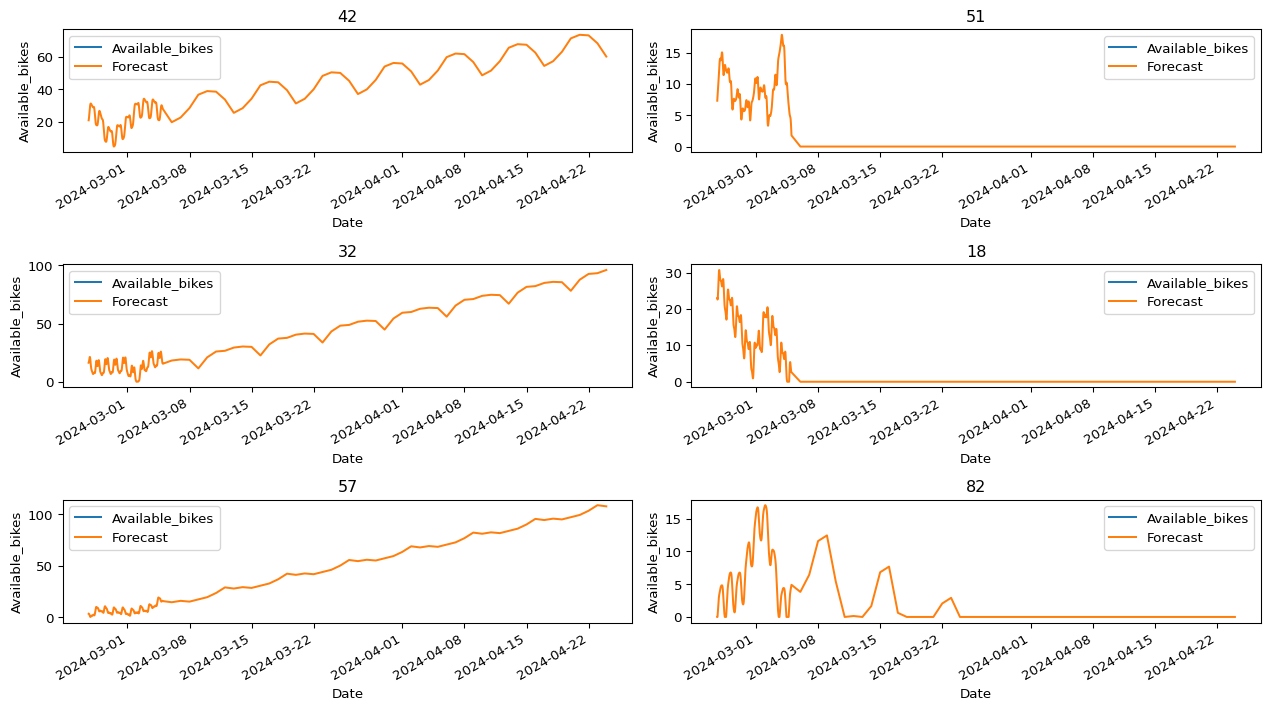

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()
for ax_ ,station_id in enumerate(p['station_id'].unique()[:6]):
    p_ = p.loc[p['station_id'] == station_id]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Available_bikes')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast')
    ax[ax_].set_title(station_id)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Available_bikes')
fig.tight_layout()
plt.show()